# Nepal Places

Cillian Berragan  
2023-10-18

The following document demonstrates the ability to easily query the
Overture dataset using this python project.

## Setup Environment

I strongly recommend you use a virtual environment to manage the
dependencies in the project. This project uses
[pdm](https://pdm.fming.dev/), however any other tool like `pip` with
`virtualenv` or `conda` could be used.

1.  Clone this repository locally:
    `git clone https://github.com/cjber/overture-uk.git`

2.  Ensure local `python` version is `3.11` or greater

3.  Install project dependencies from the `pyproject.toml` file

    -   `pip install .` for `pip`
    -   `pdm install` for `pdm`
    -   `conda install` for `conda`

## Query Overture Dataset

1.  Add the bounding box for Nepal in the `pipelines/custom/params.yaml`
    file.

``` yaml
# nepal
filename: nepal_places
bounds:
    minx: 80.0601
    maxx: 88.2040
    miny: 26.3475
    maxy: 30.4470
```

1.  Run `dvc repro pipelines/custom/params.yaml` to retrieve and clean
    the Nepal data.
    -   The cleaned dataset will be saved to
        `data/processed/nepal_places.parquet`.

> ***Note:** For large datasets, this process will take a long time.*

## Generate Analysis

The following section demonstrates an example analysis of the resultant
dataset using `geopandas` and `matplotlib`.

First we need to import the following libraries:

In [1]:
import geodatasets
import geopandas as gpd
import h3pandas
import matplotlib.pyplot as plt

-   `geodatasets` is used here to provide a national boundary for Nepal,
    which allows us to clip the results to exclude all points that are
    within the bounding box, but external to the country.
-   `geopandas` provides a variety of spatial dataframe tools, allowing
    for the geoparquet file to be read in as a dataframe, and processed.
-   `h3pandas` provides utility functions to generate H3 hexagons from
    the H3 metadata included in the processed Overture data.
-   `matplotlib` provides plotting functionality.

We then read in the dataset using `geopandas`, clipping using the Nepal
boundary and filtering out some less interesting columns, and print the
top five rows of this dataframe.

In [2]:
mask = gpd.read_file(geodatasets.get_path("geoda.nepal")).unary_union.buffer(0.01)
columns = ["names_value", "category_main", "h3_05", "geometry"]

df = gpd.read_parquet("./data/processed/nepal_places.parquet", columns=columns)
df = df.to_crs(4326).clip(mask=mask)  # non-parquet files can be clipped when read in
df.head()

The Overture data includes some data regarding place categories. The
following shows the top 5 categories for places in Nepal.

In [3]:
cats = df["category_main"].value_counts().head()
cats

category_main
hotel                                5392
public_and_government_association    3917
school                               3259
professional_services                2291
college_university                   2253
Name: count, dtype: int64

We then filter by the ‘Public and Government Association’ category and
plot the results aggregated into H3 hexagons.

In [4]:
df_filtered = (
    df[df["category_main"] == cats.keys()[1]]
    .loc[:, ["h3_05", "category_main"]]
    .assign(count=1)
    .groupby(["h3_05", "category_main"])
    .sum()
    .reset_index()
    .set_index("h3_05")
    .h3.h3_to_geo_boundary()
    .clip(mask=mask)
)
df_filtered.head()

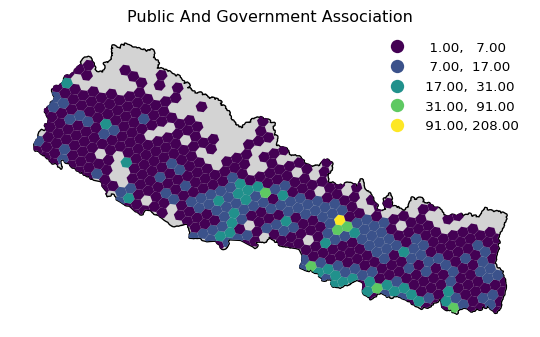

In [5]:
fig, ax = plt.subplots()

gpd.GeoSeries(mask).plot(facecolor="lightgrey", edgecolor="black", ax=ax)
df_filtered.plot("count", ax=ax, scheme="fisherjenks", legend=True, legend_kwds={"frameon":False})

ax.axis("off")

plt.title(f"{cats.keys()[1].title().replace('_', ' ')}")
plt.show()